# Introduction to AI for Quantum Error Mitigation

This notebook provides a hands-on walkthrough of an AI-based quantum error mitigation workflow. We'll use a graph neural network (GNN) to learn how to correct for noise in quantum circuits. Here's the plan:

1. **Generate Quantum Circuits**: We'll create a set of quantum circuits with varying properties.
2. **Simulate with Noise**: We'll execute these circuits on a simulated quantum computer, both with and without a noise model, to generate training data.
3. **Prepare Data**: The circuits will be converted into graph structures suitable for a GNN.
4. **Build & Train the GNN**: We'll define and train a GNN to predict the noise-free expectation values from the noisy ones.
5. **Evaluate the Model**: Finally, we'll assess the model's performance on a test set to see how well it learned to mitigate errors.


## 1. Setup and Imports

First, we'll import the necessary libraries and set up some parameters for our experiment. We'll keep the number of circuits and their complexity low to ensure the notebook runs quickly.


In [16]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer

# Import from our library
from ml_denoising.noise_modeling import get_quera_noise_model_cudaq
from ml_denoising.data_generation import generate_proper_circuits, generate_proper_observables, prepare_mitigator_dataset, qiskit_to_cudaq_kernel
from ml_denoising.circuit import circuit_to_graph_data, qasm_hash
from ml_denoising.model import build_model, visualize_embeddings
from ml_denoising.train import train_mitigator, evaluate_mitigator

import cudaq
from cudaq import spin

# --- Experiment Parameters ---
output_dir = "ml_mitigation_notebook_output"
os.makedirs(output_dir, exist_ok=True)
seed = 42

# Circuit generation
num_circuits = 200  # Keep this small for a quick run
min_qubits = 4
max_qubits = 8
min_depth = 50
max_depth = 100

# Model and Training
model_variant = 'simple' 
model_depth = 2
noise_factors = [1.0]
epochs = 100  # Keep this low for a quick demo

print(f"Output directory: {os.path.abspath(output_dir)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Output directory: /home/jovyan/ai4quantum/ml-denoising/examples/ml_mitigation_notebook_output
Using device: cuda


## 2. Generate Circuits and Observables

Now, let's generate the quantum circuits that will form the basis of our dataset. We'll create both Qiskit and CUDA-Q representations. We will also generate a corresponding set of observables (Hamiltonians) to measure.


In [17]:
qiskit_circuits, cudaq_circuits = generate_proper_circuits(
    num_circuits=num_circuits,
    min_qubits=min_qubits,
    max_qubits=max_qubits,
    min_depth=min_depth,
    max_depth=max_depth,
    seed=seed
)

qiskit_observables, cudaq_observables = generate_proper_observables(qiskit_circuits, seed=seed)

print(f"Generated {len(qiskit_circuits)} circuits.")

# Let's inspect the first circuit
print("\n--- Example Circuit ---")
example_circuit_qiskit = qiskit_circuits[0]
example_observable_cudaq = cudaq_observables[0]

print(f"Qubits: {example_circuit_qiskit.num_qubits}, Depth: {example_circuit_qiskit.depth()}")
print("Observable (Hamiltonian):", example_observable_cudaq)

example_circuit_qiskit.draw()


Generated 600 circuits.

--- Example Circuit ---
Qubits: 7, Depth: 210
Observable (Hamiltonian): (-0.687963+0i) * Z0Y2Y3Z4 + (-0.714266+0i) * Y0Y1Y2Y3Z4Z6 + (-0.575322+0i) * Y0X1X3Z4Z5X6 + (-0.985867+0i) * Z0Z1Z4X5X6 + (-0.415711+0i) * Y2Y3Y4X5Z6 + (-0.235076+0i) * Z0Y1X2X3Y4X5Y6 + (-0.658952+0i) * Z0Z1Y3Y5Y6


┌───┐          ┌───┐          ┌───┐     ┌────────────┐    ┌───┐     »
q_0: ────┤ Y ├──────────┤ Z ├──────────┤ Y ├─────┤ Rx(1.4507) ├────┤ X ├─────»
     ┌───┴───┴────┐ ┌───┴───┴────┐     ├───┤     └───┬───┬────┘    ├───┤     »
q_1: ┤ Rx(3.7501) ├─┤ Rx(3.8798) ├─────┤ Z ├─────────┤ Z ├─────────┤ X ├─────»
     └───┬───┬────┘ └───┬───┬────┘     ├───┤         ├───┤         ├───┤     »
q_2: ────┤ X ├──────────┤ X ├──────────┤ Z ├─────────┤ Z ├─────────┤ Z ├─────»
         ├───┤     ┌────┴───┴─────┐    ├───┤         ├───┤         ├───┤     »
q_3: ────┤ Y ├─────┤ Ry(0.044399) ├────┤ H ├─────────┤ Z ├─────────┤ X ├─────»
         ├───┤     └────┬───┬─────┘    ├───┤     ┌───┴───┴────┐    ├───┤     »
q_4: ────┤ Y ├──────────┤ H ├──────────┤ Y ├─────┤ Rx(5.2351) ├────┤ X ├─────»
         ├───┤          ├───┤      ┌───┴───┴────┐└───┬───┬────┘┌───┴───┴────┐»
q_5: ────┤ Y ├──────────┤ H ├──────┤ Rx(3.8173) ├────┤ Y ├─────┤ Ry(5.8224) ├»
     ┌───┴───┴────┐     ├───┤      ├────────────┤┌───┴───┴────┐├────────────┤»
q_6: ┤ Rx(3.7769) ├─────┤ Y ├──────┤ Rx(2.8306) ├┤ Ry(2.4571) ├┤ Ry(1.2314) ├»
     └────────────┘     └───┘      └────────────┘└────────────┘└────────────┘»
«          ┌───┐     ┌────────────┐    ┌───┐          ┌───┐         ┌───┐     »
«q_0: ─────┤ Z ├─────┤ Rx(5.8201) ├────┤ Y ├──────────┤ Z ├─────────┤ X ├─────»
«          ├───┤     └───┬───┬────┘    ├───┤      ┌───┴───┴────┐┌───┴───┴────┐»
«q_1: ─────┤ Z ├─────────┤ X ├─────────┤ H ├──────┤ Rx(1.2674) ├┤ Rx(1.8575) ├»
«          ├───┤         ├───┤         ├───┤      └───┬───┬────┘├────────────┤»
«q_2: ─────┤ Z ├─────────┤ H ├─────────┤ Y ├──────────┤ H ├─────┤ Rx(5.4755) ├»
«     ┌────┴───┴────┐    ├───┤     ┌───┴───┴────┐     ├───┤     └───┬───┬────┘»
«q_3: ┤ Rx(0.88545) ├────┤ Z ├─────┤ Rx(6.1054) ├─────┤ Z ├─────────┤ Z ├─────»
«     ├─────────────┤    ├───┤     └───┬───┬────┘ ┌───┴───┴────┐    ├───┤     »
«q_4: ┤ Rx(0.46842) ├────┤ H ├─────────┤ Y ├──────┤ Rx(3.1954) ├────┤ Z ├─────»
«     └────┬───┬────┘    ├───┤         ├───┤     ┌┴────────────┤    ├───┤     »
«q_5: ─────┤ H ├─────────┤ Z ├─────────┤ H ├─────┤ Ry(0.87545) ├────┤ Z ├─────»
«          ├───┤         ├───┤     ┌───┴───┴────┐└┬────────────┤    ├───┤     »
«q_6: ─────┤ H ├─────────┤ X ├─────┤ Rx(3.5266) ├─┤ Rx(3.3919) ├────┤ Z ├─────»
«          └───┘         └───┘     └────────────┘ └────────────┘    └───┘     »
«           ┌───┐      ┌────────────┐     ┌───┐         ┌───┐     ┌───┐»
«q_0: ──────┤ H ├──────┤ Ry(1.3745) ├─────┤ X ├─────────┤ Y ├─────┤ Z ├»
«           ├───┤      └───┬───┬────┘     ├───┤         ├───┤     ├───┤»
«q_1: ──────┤ H ├──────────┤ H ├──────────┤ X ├─────────┤ Y ├─────┤ Y ├»
«           ├───┤          ├───┤          ├───┤         ├───┤     ├───┤»
«q_2: ──────┤ H ├──────────┤ Z ├──────────┤ Z ├─────────┤ H ├─────┤ Z ├»
«           ├───┤          ├───┤     ┌────┴───┴────┐┌───┴───┴────┐├───┤»
«q_3: ──────┤ Y ├──────────┤ H ├─────┤ Ry(0.20766) ├┤ Ry(2.3108) ├┤ Y ├»
«     ┌─────┴───┴─────┐┌───┴───┴────┐└────┬───┬────┘└───┬───┬────┘├───┤»
«q_4: ┤ Ry(0.0032696) ├┤ Ry(6.1059) ├─────┤ H ├─────────┤ Z ├─────┤ X ├»
«     └─┬────────────┬┘└───┬───┬────┘     ├───┤         ├───┤     ├───┤»
«q_5: ──┤ Rx(5.4081) ├─────┤ Z ├──────────┤ H ├─────────┤ X ├─────┤ Y ├»
«       ├────────────┤     ├───┤          ├───┤     ┌───┴───┴────┐├───┤»
«q_6: ──┤ Ry(3.2091) ├─────┤ Z ├──────────┤ Y ├─────┤ Ry(2.5059) ├┤ Y ├»
«       └────────────┘     └───┘          └───┘     └────────────┘└───┘»
«         ┌───┐         ┌───┐     ┌───────────┐     ┌───┐         ┌───┐     »
«q_0: ────┤ H ├─────────┤ H ├─────┤ Ry(5.907) ├─────┤ H ├─────────┤ H ├─────»
«         ├───┤         ├───┤     └───┬───┬───┘     ├───┤     ┌───┴───┴────┐»
«q_1: ────┤ H ├─────────┤ H ├─────────┤ H ├─────────┤ Z ├─────┤ Rx(1.4463) ├»
«         ├───┤         ├───┤     ┌───┴───┴────┐    ├───┤     └───┬───┬────┘»
«q_2: ────┤ X ├─────────┤ Y ├─────┤ Rx(1.7839) ├────┤ Y ├─────────┤ Y ├─────»
«     ┌───┴───┴────┐    ├───┤     ├────────────┤    ├───┤    

## 3. Simulate Noisy vs. Noiseless Executions

To train our model, we need pairs of noisy and ideal (noiseless) expectation values. Let's define a noise model and run our example circuit to see the impact of noise firsthand.


In [18]:
n_qubits = max(c.num_qubits for c in qiskit_circuits)
zero_noise_model = cudaq.NoiseModel()

example_kernel= qiskit_to_cudaq_kernel(qiskit_circuits[0])
example_H = cudaq_observables[0]

# --- Noiseless Execution ---
noiseless_result = cudaq.observe(example_kernel, example_H, noise_model=zero_noise_model)
noiseless_exp = noiseless_result.expectation()

noise_model = get_quera_noise_model_cudaq(n_qubits, 1.0)
# --- Noisy Execution ---
noisy_result = cudaq.observe(example_kernel, example_H, noise_model=noise_model)
noisy_exp = noisy_result.expectation()

print(f"Noiseless expectation: {noiseless_exp:.6f}")
print(f"Noisy expectation:     {noisy_exp:.6f}")
print(f"Error induced by noise: {abs(noiseless_exp - noisy_exp):.6f}")


Noiseless expectation: -0.175575
Noisy expectation:     -0.138778
Error induced by noise: 0.036797


## 4. Generate Full Dataset

Now we'll repeat the simulation for all our generated circuits to create the full dataset. This will then be processed into a format suitable for training.


In [19]:
from tqdm.notebook import tqdm

data_pairs = list(zip(cudaq_circuits, cudaq_observables))

noiseless_vals, noisy_vals = [], []

print(f"Running simulations for {len(data_pairs)} circuit-observable pairs...")
for kernel, H in tqdm(data_pairs):
    # Noiseless
    res0 = cudaq.observe(kernel, H, noise_model=zero_noise_model)
    noiseless_vals.append(float(res0.expectation()))

    # Noisy
    res1 = cudaq.observe(kernel, H, noise_model=noise_model)
    noisy_vals.append(float(res1.expectation()))

print("Simulations complete.")

# Prepare dataset for the model
dataset = prepare_mitigator_dataset(
    [qiskit_circuits],  # all_circuits_by_nf
    [cudaq_observables],  # all_observables_by_nf
    [noisy_vals],      # all_noisy_values_by_nf
    [noiseless_vals],  # all_noiseless_values_by_nf
    noise_factors
)

print(f"\nDataset prepared with {len(dataset)} entries.")

Running simulations for 600 circuit-observable pairs...


  0%|          | 0/600 [00:00<?, ?it/s]

Simulations complete.

Dataset prepared with 600 entries.


## 5. Convert Circuits to Graphs

Our GNN model doesn't work with quantum circuits directly; it works with graphs. We need to convert each circuit into a graph representation. Let's see what this looks like for our example circuit. This step is also where we determine the size of the input features for our neural network.


In [21]:
# Convert a sample qiskit circuit to a graph
sample_graph_data = circuit_to_graph_data(qiskit_circuits[0])

# Extract feature sizes from the graph data tensor shapes
node_feature_size = sample_graph_data.x.shape[1]

print(f"Node feature size: {node_feature_size}")
print("\n--- Sample Graph Data Object ---")
print(sample_graph_data)


Node feature size: 47

--- Sample Graph Data Object ---
Data(x=[794, 47], edge_index=[2, 1021], edge_attr=[1021, 2], global_features=[1, 12])


## 6. Split Dataset for Training and Testing

To properly evaluate our model, we need to split our data into a training set and a test set. It's crucial to ensure that circuits in the test set have not been seen by the model during training, so we'll split based on unique circuit hashes.


In [22]:
from sklearn.model_selection import train_test_split

# Group dataset entries by circuit
circuit_to_entries = {}
for entry in dataset:
    circuit_hash = qasm_hash(entry['circuit'])
    if circuit_hash not in circuit_to_entries:
        circuit_to_entries[circuit_hash] = []
    circuit_to_entries[circuit_hash].append(entry)

unique_hashes = list(circuit_to_entries.keys())

# Split the hashes
train_hashes, test_hashes = train_test_split(unique_hashes, test_size=0.25, random_state=seed)

# Create the final datasets
train_dataset = [entry for h in train_hashes for entry in circuit_to_entries[h]]
test_dataset = [entry for h in test_hashes for entry in circuit_to_entries[h]]

print(f"Training set size: {len(train_dataset)} entries ({len(train_hashes)} unique circuits)")
print(f"Test set size:     {len(test_dataset)} entries ({len(test_hashes)} unique circuits)")


Training set size: 450 entries (450 unique circuits)
Test set size:     150 entries (150 unique circuits)


## 7. Build the GNN Model

Now we'll construct the GNN. The `build_model` function creates an architecture based on the specified variant and depth. Let's look at the model structure.


In [23]:
model = build_model(
    model_variant,
    node_fs=node_feature_size,
    device=device,
    depth=model_depth
)

print(model)


Building model variant: 'simple' with depth: 2
Model has 33,361 trainable parameters
QErrorMitigationModel(
  (conv_layers): ModuleList(
    (0): GATv2Conv(47, 128, heads=1)
    (1): GATv2Conv(128, 32, heads=1)
  )
  (obs_encoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
  )
  (noise_encoder): Linear(in_features=1, out_features=4, bias=True)
  (fusion): Sequential(
    (0): Linear(in_features=45, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)


## 8. Train the Error Mitigation Model

With the data prepared and the model built, it's time for training! The `train_mitigator` function will handle the training loop, validation, and learning rate scheduling. We'll plot the training and validation loss to monitor learning.


Epoch 1/100, Train Loss: 0.005622, Val Loss: 0.000937, LR: 0.001000, Time: 0.21s


Epoch 10/100, Train Loss: 0.000160, Val Loss: 0.000050, LR: 0.001000, Time: 0.20s


Epoch 20/100, Train Loss: 0.000058, Val Loss: 0.000021, LR: 0.001000, Time: 0.21s


Epoch 30/100, Train Loss: 0.000036, Val Loss: 0.000018, LR: 0.000500, Time: 0.21s


Epoch 40/100, Train Loss: 0.000036, Val Loss: 0.000019, LR: 0.000250, Time: 0.20s


Epoch 50/100, Train Loss: 0.000029, Val Loss: 0.000019, LR: 0.000125, Time: 0.21s


Early stopping at epoch 52 due to no improvement in validation loss for 10 epochs.


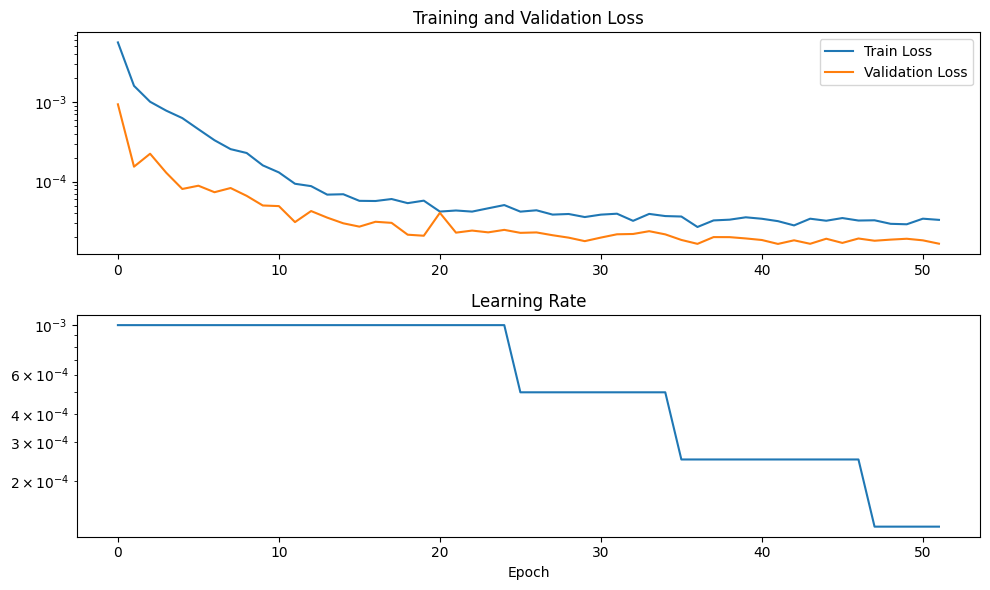

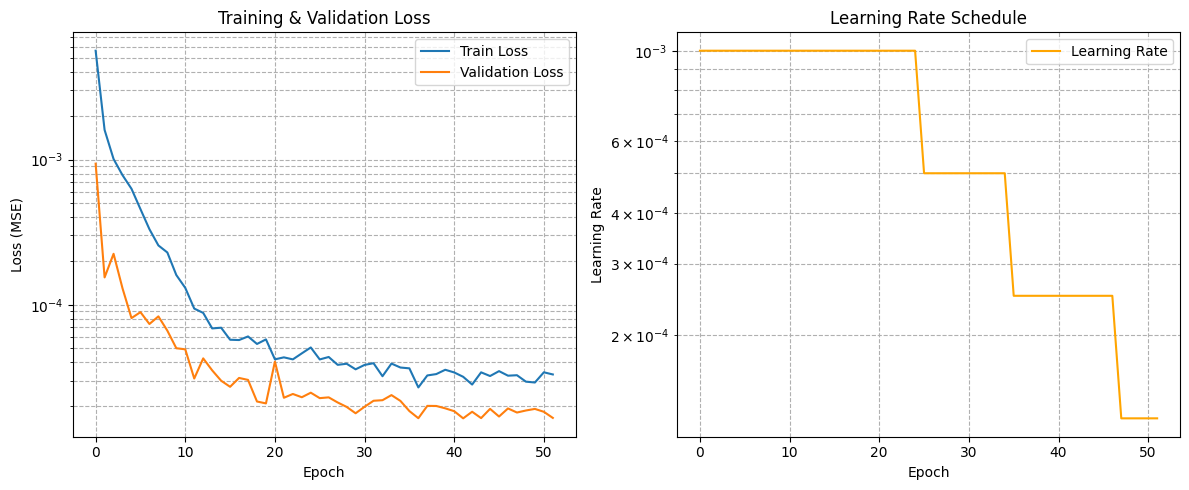

In [24]:
trained_model, history = train_mitigator(
    train_dataset,
    model,
    epochs=epochs,
    batch_size=16,
    lr=0.001,
    device=device
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.subplot(1, 2, 2)
plt.plot(history['learning_rates'], label='Learning Rate', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


## 9. Evaluate Model Performance

Training is complete. How well did our model learn to mitigate errors? We'll use the `evaluate_mitigator` function, which calculates several key metrics and generates plots to compare the noisy, corrected, and ideal expectation values.



--- Error Mitigation Evaluation ---
  Mean Noisy Error:      0.0050 (95% CI: [0.0034, 0.0067])
  Mean Mitigated Error:  0.0028 (95% CI: [0.0020, 0.0037])
  Error Reduction:       43.77% (95% CI: [43.31%, 44.24%])
  R-squared (R²):        0.9987
------------------------------------
--- Evaluation Metrics ---
{
  "mean_noisy_error": 0.005011482164263725,
  "mean_mitigated_error": 0.0027786593418568373,
  "error_reduction_percentage": 43.76580913960934,
  "r2_score": 0.9986593127250671
}


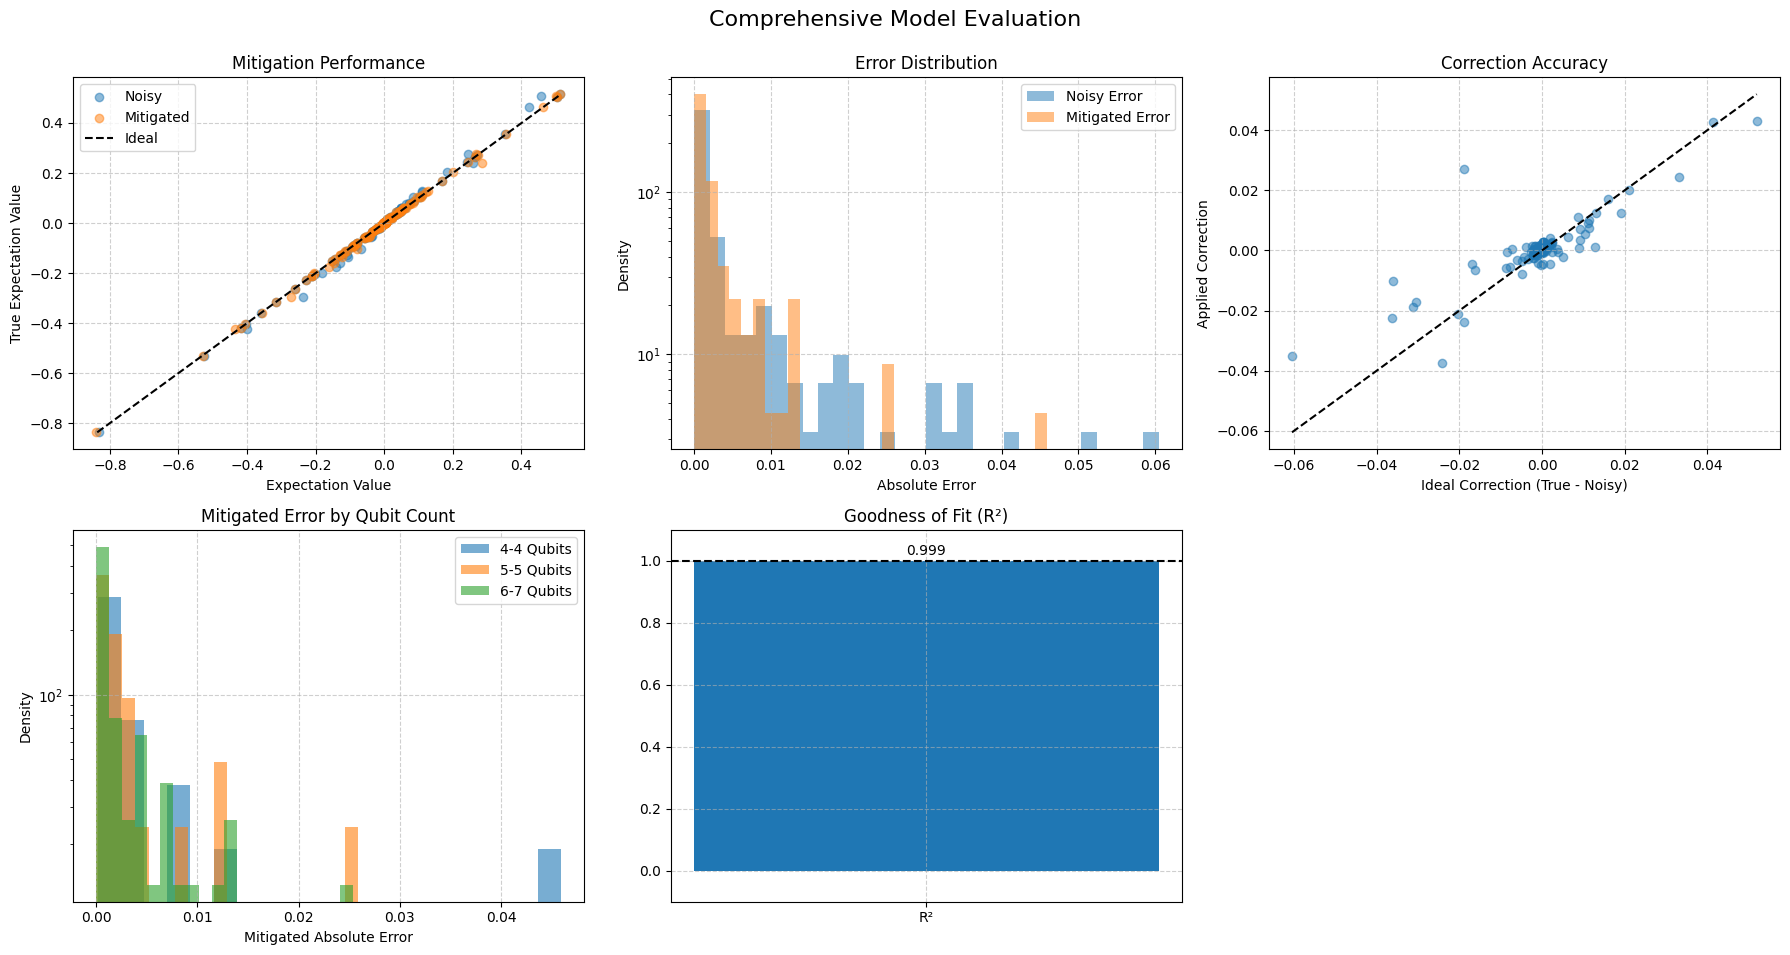

In [28]:
# The evaluate_mitigator function saves plots to disk, we will load and show them here.
eval_results = evaluate_mitigator(
    trained_model, 
    test_dataset, 
    device=device, 
    output_prefix=output_dir
)

print("--- Evaluation Metrics ---")
print(json.dumps(eval_results['metrics'], indent=2))


